In [349]:
import pandas as pd
import numpy as np
from collections import Counter, defaultdict
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler
from statsmodels.discrete.discrete_model import Logit
import sklearn.model_selection as cv
import sklearn.metrics as metrics
from statsmodels.tools import add_constant

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, IsolationForest
from xgboost import XGBClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SVMSMOTE
from imblearn.under_sampling import RandomUnderSampler
import pymc3 as pm

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
df = pd.read_csv('data/train.csv')
df.head()

,amount,hour,account_id,field1,field2,flag1,field3,field4,indicator1,indicator2,flag2,flag4,flag5,fraud
0,12.95,0,1234567890123456,0,0,0,-723,19,0,0,0,0,1,0
1,38.85,0,1234567890123460,3,1,0,-4074,21,0,0,1,0,1,0
2,12.95,0,1234567890123461,3,0,1,-2753,24,0,0,1,0,1,0
3,10.36,0,1234567890123463,3,1,1,5927,7,0,0,1,0,2,0
4,49.95,0,1234567890123464,3,0,1,4942,9,0,0,1,0,1,0


In [69]:
y = df['fraud']
X = df.drop(columns='fraud')
X_train, X_test, y_train, y_test = train_test_split(StandardScaler().fit_transform(X.values), y.values, random_state=7, stratify=y.values)

In [70]:
(y_train == 0).sum()

48079

In [6]:
train_matrix = np.array([[(y_train == 0).sum(),0], [0, (y_train == 1).sum()]])
test_matrix = np.array([[(y_test == 0).sum(),0], [0, (y_test == 1).sum()]])

In [7]:
train_matrix

array([[48079,     0],
       [    0,  1279]])

In [8]:
test_matrix

array([[16026,     0],
       [    0,   427]])

In [12]:
'''def model_scores(X, y, estimator, p=False, train=False):
    if train:
        scores = cv.cross_validate(estimator, X, y, scoring=['accuracy', 'precision', 'recall', 'neg_log_loss'], cv=5)
        acc = np.mean(scores['test_accuracy'])
        precision = np.mean(scores['test_precision'])
        recall = np.mean(scores['test_recall'])
        log_loss = -np.mean(scores['test_neg_log_loss'])
    else:
        y_hat = estimator.predict(X)
        acc = metrics.accuracy_score(y, y_hat)
        precision = metrics.precision_score(y, y_hat)
        recall = metrics.recall_score(y, y_hat)
        log_loss = metrics.log_loss(y, estimator.predict_proba(X))
    if p:
        print ("Accuracy: {0:2.3} | Precision: {1} | Recall: {2} | Log_loss: {3:2.3}".format(
                                                                    acc, precision, recall, log_loss))                                                           
    else:
        return acc, precision, recall, log_loss'''

In [53]:
LR = LogisticRegression(solver='lbfgs',max_iter=1000, class_weight='balanced', tol=.0001)

In [30]:
#const_X_train = add_constant(X_train, prepend=True)
#scaled_Xtrain = StandardScaler().fit_transform(X_train)

In [71]:
LR.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [127]:
LR.predict_proba(X_train)

0.9998526078707068

In [428]:
def predict(model, X, threshold=0.5):
    '''Return prediction of the fitted binary-classifier model model on X using
    the specifed `threshold`. NB: class 0 is the positive class'''
    return np.where(model.predict_proba(X)[:, 1] > threshold,
                    model.classes_[1],
                    model.classes_[0])

def confusion_matrix(model, X, y, threshold=0.5):
    cf = pd.crosstab(y, predict(model, X, threshold))
    cf = cf.rename(columns={0:'Not', 1:'Fraud'}, index={0:'Not', 1:'Fraud'})
    cf.index.name = 'actual'
    cf.columns.name = 'predicted'
    return cf

def total_cost(predicted, cb=cost_benefit):
    cost = predicted*cb
    return cost.values.sum()

In [190]:
cost_benefit = np.array([[0, -10],[-27,5]])
cost_benefit

array([[  0, -10],
       [-27,   5]])

In [202]:
confusion_matrix(LR, X_test, y_test, threshold=.1)

predicted,Not,Fraud
actual,,
Not,16022,4
Fraud,427,0


Text(0.5, 1.0, 'Profit Curve')

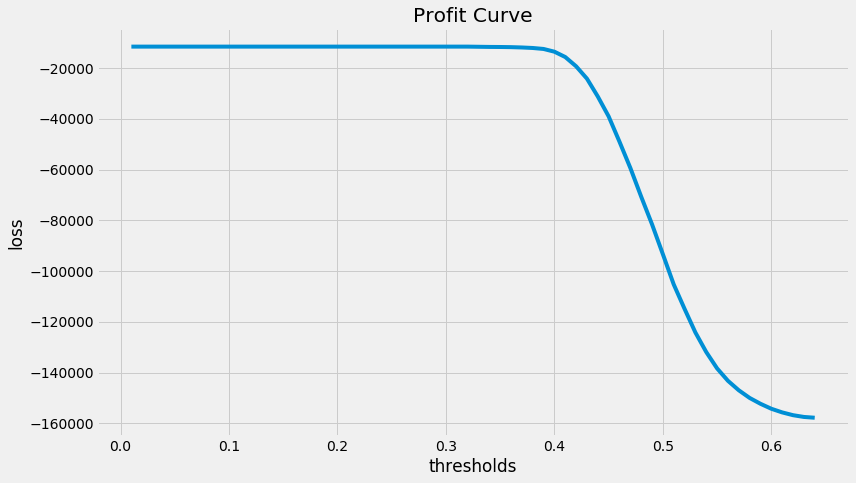

In [204]:
thresholds = np.arange(0.01, 0.65, 0.01)
profits = []
for threshold in thresholds:
    profits.append(total_cost(confusion_matrix(LR, X_test, y_test, threshold=threshold)))
    
fig, ax = plt.subplots(figsize=(12, 7))
ax.plot(thresholds, profits)
ax.set_xlabel('thresholds')
ax.set_ylabel('loss')
ax.set_title('Profit Curve')

In [44]:
#WELL SHIT

In [227]:
dummy_df = pd.read_pickle('data/dummy_train.pkl')

In [300]:
dummy_df.head()

,amount,hour,account_id,field2,flag1,field3,indicator1,indicator2,flag2,flag3,...,flag5_6,flag5_7,flag5_8,flag5_9,flag5_98,flag5_100,flag5_364,flag5_1434,flag5_1600,flag5_1643
0,12.95,0,1234567890123456,0,0,-723,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,38.85,0,1234567890123458,1,0,-4420,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
3,12.95,0,1234567890123459,0,0,5010,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,38.85,0,1234567890123460,1,0,-4074,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
5,12.95,0,1234567890123461,0,1,-2753,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0


In [301]:
y = dummy_df['fraud']
X = dummy_df.drop(columns='fraud')
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, random_state=7, stratify=y.values)

In [240]:
RFC = RandomForestClassifier(n_estimators=20, class_weight={0:1,1:150}, n_jobs=-1)
RFC.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 1, 1: 150}, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=20, n_jobs=-1, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

In [287]:
def print_results(X, y, model, threshold=.1, p=True):
    if p:
        yhat = predict(model, X, threshold)
    else:
        yhat = model.predict(X)
    tn, fp, fn, tp = metrics.confusion_matrix(y, yhat).flatten()
    print ('  TP  |  FN  |  FP  |  TN  ')
    print ('--------------------------')
    print(f'{tp:6d}|{fn:6d}|{fp:6d}|{tn:6d}')
    print ('--------------------------')
    recall = metrics.recall_score(y, yhat)
    roc = metrics.roc_auc_score(y, yhat)
    f1 = metrics.f1_score(y, yhat)
    print(f'Recall:  {recall:0.4g}')
    print(f'ROC_AUC: {roc:.4f}')
    print(f'F1:      {f1:.4f}')

In [257]:
print ('Training Data | Simple Random Forest')
print_results(X_train, y_train, RFC)
print ('')
print ('Testing  Data | Simple Random Forest')
print_results(X_test, y_test, RFC, .2)

Training Data | Simple Random Forest
  TP  |  FN  |  FP  |  TN  
--------------------------
     0|  1354| 49253|   395
--------------------------
Recall:  0
ROC_AUC: 0.0040

Testing  Data | Simple Random Forest
  TP  |  FN  |  FP  |  TN  
--------------------------
   441|    11| 16382|   167
--------------------------
Recall:  0.9757
ROC_AUC: 0.4929


In [42]:
feature_importances = RFC.feature_importances_
features = df.columns[:-1]
order = np.argsort(feature_importances)[::-1]
for feat_score, feature in zip(feature_importances[order][:5], features[order][:5]):
    print (f'{feature}: {feat_score}')

field3: 0.45673968367419
field4: 0.1686054838530603
hour: 0.14267936800228714
amount: 0.08669534756324268
field1: 0.04604653258973908


In [51]:
importances = np.empty((100, len(df.columns[:-1])))
for i, tree in enumerate(RFC.estimators_):
    importances[i, :] = tree.feature_importances_

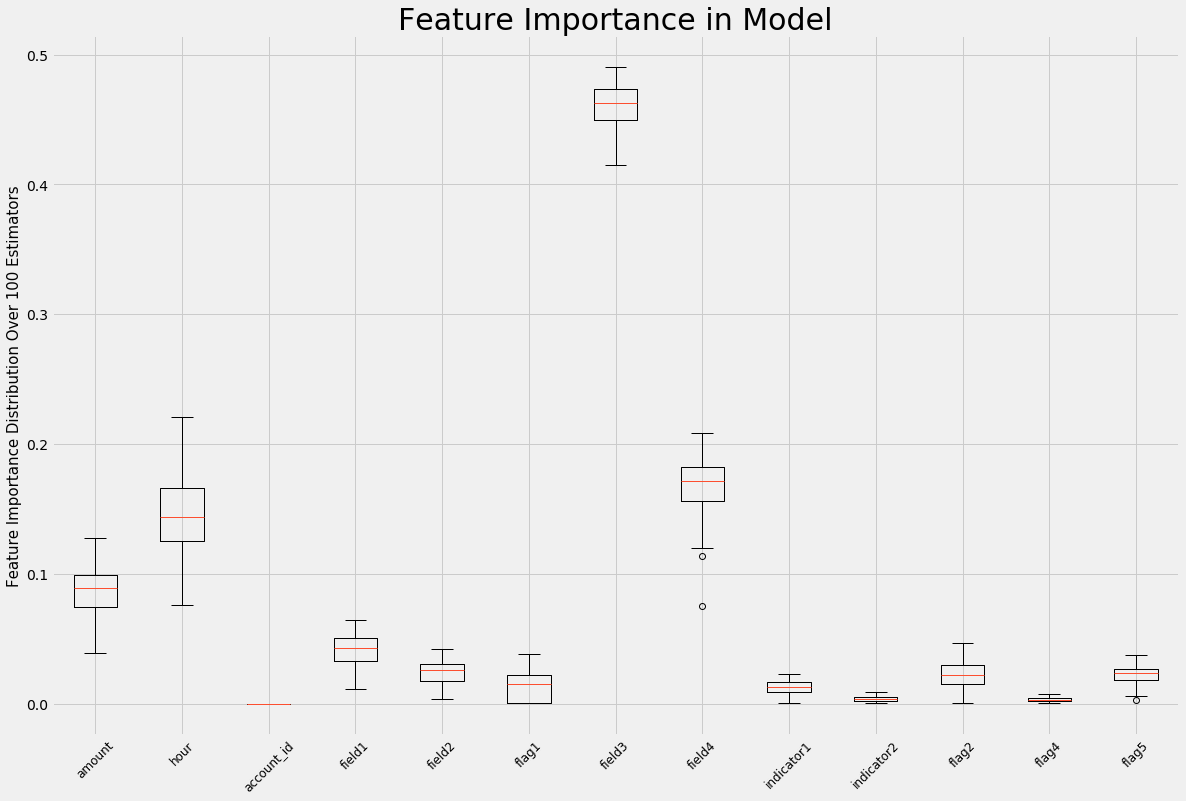

In [53]:
'''fig, ax = plt.subplots(figsize=(18, 12))
ax.boxplot(importances, labels=df.columns[:-1])
ax.set_ylabel('Feature Importance Distribution Over 100 Estimators', fontsize=15)
ax.set_xticklabels(labels=df.columns[:-1], rotation=45, fontsize=12)
ax.set_title('Feature Importance in Model', fontsize=30)
fig.savefig('FeatureImportance.png');'''

In [346]:
over = SVMSMOTE(sampling_strategy=0.1)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('over', over), ('under', under), ('model', rf_best_estimator)]
pipeline = Pipeline(steps=steps)

In [352]:
cv_ = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
scores = cross_val_score(pipeline, X_train, y_train, scoring='roc_auc', cv=cv_, n_jobs=-1)
print('Mean ROC AUC: %.3f' % np.mean(scores))

Mean ROC AUC: 0.538


In [358]:
metrics.f1_score(y_test, pipeline.predict(X_test))

/Library/Python/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.0

In [357]:
#pipeline.fit(X_train, y_train)

In [224]:
print ('Training Data | Smote Sampled Random Forest')
print_results(X_train, y_train, RFC)
print ('')
print ('Testing  Data | Smote Sampled Random Forest')
print_results(X_test, y_test, RFC)

Training Data | Smote Sampled Random Forest
  TP  |  FN  |  FP  |  TN  
--------------------------
     7|  1347| 49560|    88
--------------------------
Recall:  0.00517
ROC_AUC: 0.0035

Testing  Data | Smote Sampled Random Forest
  TP  |  FN  |  FP  |  TN  
--------------------------
   448|     4| 16502|    47
--------------------------
Recall:  0.9912
ROC_AUC: 0.4970


Text(0, 0.5, 'loss')

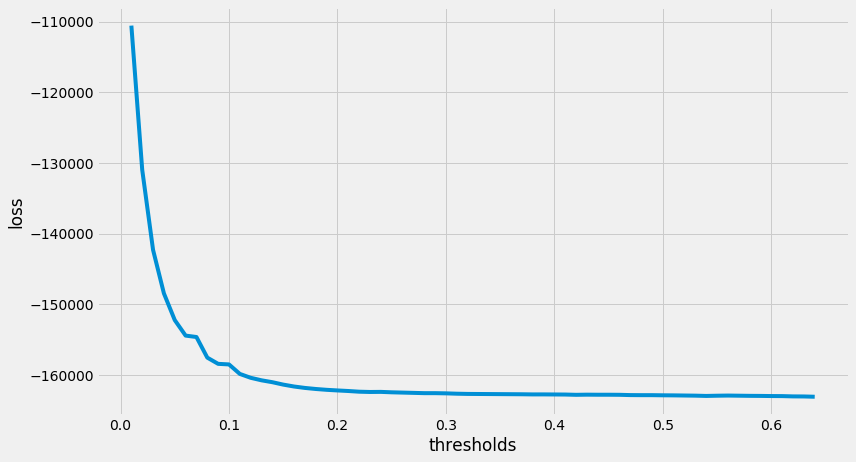

In [217]:
thresholds = np.arange(0.01, 0.65, 0.01)
profits = []
for threshold in thresholds:
    profits.append(total_cost(confusion_matrix(RFC, X_test, y_test, threshold=threshold)))
    
fig, ax = plt.subplots(figsize=(12, 7))
ax.plot(thresholds, profits)
ax.set_xlabel('thresholds')
ax.set_ylabel('loss')

In [221]:
confusion_matrix(RFC, X_test, y_test, threshold=.0001)

predicted,Not,Fraud
actual,,
Not,9970,6579
Fraud,270,182


In [263]:
random_forest_grid = {'criterion':['entropy', 'gini'],
                      'max_depth': [None, 1, 2],
                      'max_features': ['sqrt','log2'],
                      'min_samples_split': [0,2,5,8],
                      'min_samples_leaf': [5,10,15],
                      'bootstrap': [True],
                      'n_estimators': [20, 50, 100],
                      'random_state': [7]}

cv_ = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)

rf_gridsearch = cv.GridSearchCV(RandomForestClassifier(),
                             random_forest_grid,
                             n_jobs=-1,
                             verbose=True,
                             scoring='f1',
                             cv=cv_)

rf_gridsearch.fit(X_train, y_train)

print("best parameters:        ", rf_gridsearch.best_params_)

rf_best_estimator = rf_gridsearch.best_estimator_
print('best estimator:         ', rf_best_estimator)

rf_best_prediction = rf_best_estimator.predict(X_test)
print('Accuracy  of best: ', metrics.accuracy_score(y_test, rf_best_prediction))
print('Precision of best: ', metrics.precision_score(y_test, rf_best_prediction))
print('Recall    of best: ', metrics.recall_score(y_test, rf_best_prediction))

Fitting 15 folds for each of 432 candidates, totalling 6480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed: 11.2min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 12.1min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed: 13.3min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed: 15.0min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed: 23.9min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed: 28.8min
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed: 31.6min
[Parallel(n_jobs=-1)]: Done 6480 out of 6480 | elapsed: 32.9min finished


best parameters:         {'bootstrap': True, 'criterion': 'entropy', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 20, 'random_state': 7}
best estimator:          RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=20,
                       n_jobs=None, oob_score=False, random_state=7, verbose=0,
                       warm_start=False)
Accuracy  of best:  0.9734133286277278
Precision of best:  0.0
Recall    of best:  0.0


/Library/Python/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [303]:
rf_best_estimator.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=20,
                       n_jobs=None, oob_score=False, random_state=7, verbose=0,
                       warm_start=False)

In [315]:
print ('Training Data | Simple Random Forest')
print_results(X_train, y_train, rf_best_estimator, y_train.mean())
print ('')
print ('Testing  Data | Simple Random Forest')
print_results(X_test, y_test, rf_best_estimator, y_train.mean())

Training Data | Simple Random Forest
  TP  |  FN  |  FP  |  TN  
--------------------------
   861|   493| 49475|   173
--------------------------
Recall:  0.6359
ROC_AUC: 0.3197
F1:      0.0333

Testing  Data | Simple Random Forest
  TP  |  FN  |  FP  |  TN  
--------------------------
   241|   211|  9716|  6833
--------------------------
Recall:  0.5332
ROC_AUC: 0.4730
F1:      0.0463


In [374]:
iso = IsolationForest(contamination=.05, bootstrap=True, n_jobs=-1)

In [375]:
iso.fit(X_train, y_train)

IsolationForest(behaviour='deprecated', bootstrap=True, contamination=0.05,
                max_features=1.0, max_samples='auto', n_estimators=100,
                n_jobs=-1, random_state=None, verbose=0, warm_start=False)

In [420]:
def iso_score(X, y, model, thresh=0):
    #yhat = (model.predict(X) == -1).astype(int)
    
    yhat = model.decision_function(X)
    preds = int(thresh*len(yhat))
    cutoff = np.argsort(yhat)[preds]
    yhat = (yhat <= ht[cutoff]).astype(int)
    
    tn, fp, fn, tp = metrics.confusion_matrix(y, yhat).flatten()
    print ('  TP  |  FN  |  FP  |  TN  ')
    print ('--------------------------')
    print(f'{tp:6d}|{fn:6d}|{fp:6d}|{tn:6d}')
    print ('--------------------------')
    recall = metrics.recall_score(y, yhat)
    roc = metrics.roc_auc_score(y, yhat)
    f1 = metrics.f1_score(y, yhat)
    print(f'Recall:  {recall:0.4g}')
    print(f'ROC_AUC: {roc:.4f}')
    print(f'F1:      {f1:.4f}')

In [378]:
ht = iso.decision_function(X_train)

In [413]:
preds = int(.*len(ht))
cutoff = np.argsort(ht)[preds]
print (cutoff)
yhat = (ht <= ht[cutoff]).astype(int)
metrics.confusion_matrix(y_train, yhat)

7878


array([[  493, 49155],
       [   17,  1337]])

In [415]:
50000/(98*2)

255.10204081632654

In [382]:
ht[]

-0.07237718327071274

In [422]:
print ('Training Data | Simple ISO Forest')
iso_score(X_train, y_train, iso, .7)
print ('')
print ('Testing  Data | Simple ISOForest')
iso_score(X_test, y_test, iso, .7)

Training Data | Simple ISO Forest
  TP  |  FN  |  FP  |  TN  
--------------------------
   948|   406| 34754| 14894
--------------------------
Recall:  0.7001
ROC_AUC: 0.5001
F1:      0.0512

Testing  Data | Simple ISOForest
  TP  |  FN  |  FP  |  TN  
--------------------------
   152|   300|  5703| 10846
--------------------------
Recall:  0.3363
ROC_AUC: 0.4958
F1:      0.0482


In [326]:
(ht < 0).sum()

136

In [ ]:
gradient_boosted_grid = {'loss':['exponential', 'deviance'],
                         'max_depth': [None],
                         'max_features': ['sqrt'],
                         'min_samples_leaf': [2, 5],
                         'n_estimators': [200],
                         'random_state': [2]}

gbr_gridsearch = cv.GridSearchCV(GradientBoostingClassifier(),
                             gradient_boosted_grid,
                             n_jobs=-1,
                             verbose=True,
                             scoring='f1',
                             cv=cv_)
gbr_gridsearch.fit(X_train, y_train)

print("best parameters:        ", gbr_gridsearch.best_params_)

gbr_best_estimator = gbr_gridsearch.best_estimator_
print('best estimator:         ', gbr_best_estimator)

gbr_best_prediction = gbr_best_estimator.predict(X_test)
print('Accuracy  of best: ', metrics.accuracy_score(y_test, gbr_best_prediction))
print('Precision of best: ', metrics.precision_score(y_test, gbr_best_prediction))
print('Recall    of best: ', metrics.recall_score(y_test, gbr_best_prediction))

In [416]:
GBR = GradientBoostingClassifier()

In [417]:
GBR.fit(X_train, y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [429]:
print ('Training Data | Simple Random Forest')
print_results(X_train, y_train, GBR, y_train.mean())
print ('')
print ('Testing  Data | Simple Random Forest')
print_results(X_test, y_test, GBR, y_train.mean())

Training Data | Simple Random Forest
  TP  |  FN  |  FP  |  TN  
--------------------------
   978|   376| 24030| 25618
--------------------------
Recall:  0.7223
ROC_AUC: 0.6191
F1:      0.0742

Testing  Data | Simple Random Forest
  TP  |  FN  |  FP  |  TN  
--------------------------
   262|   190|  8103|  8446
--------------------------
Recall:  0.5796
ROC_AUC: 0.5450
F1:      0.0594


In [433]:
over = SVMSMOTE(sampling_strategy=0.1, k_neighbors=8)
under = RandomUnderSampler(sampling_strategy=0.6, replacement=True)
steps = [('over', over), ('under', under), ('model', GBR)]
pipeline = Pipeline(steps=steps)

cv_ = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
scores = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=cv_, n_jobs=-1)
print('Mean ROC AUC: %.3f' % np.mean(scores))

Mean ROC AUC: 0.551


,amount,hour,account_id,field2,flag1,field3,indicator1,indicator2,flag2,flag3,...,flag5_6,flag5_7,flag5_8,flag5_9,flag5_98,flag5_100,flag5_364,flag5_1434,flag5_1600,flag5_1643
0,12.95,0,1234567890123456,0,0,-723,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,38.85,0,1234567890123458,1,0,-4420,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
3,12.95,0,1234567890123459,0,0,5010,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,38.85,0,1234567890123460,1,0,-4074,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
5,12.95,0,1234567890123461,0,1,-2753,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97996,10.36,14,1234567890194145,1,1,5169,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
97997,38.85,14,1234567890197179,1,0,5427,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
98000,49.95,14,1234567890197182,0,0,393,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
98001,11.01,14,1234567890196488,1,1,4261,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
